In [73]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

# from utils.helper import fn_plot_confusion_matrix

In [74]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [75]:
altName = 'all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
BATCH_SIZE = 32 # batch size for training   
TRAIN_SIZE = BATCH_SIZE * 9

EPOCHS = 100 # number of cycles to run
ALPHA = 0.001 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [76]:
filepath = 'weatherHistory.csv'
data_df = pd.read_csv(filepath)
data_df.shape

(96453, 12)

In [77]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [78]:
cols = data_df.columns

for col in cols:
    print(f"\nColumns Name:{col} : {data_df[col].unique()}")


Columns Name:Formatted Date : ['2006-04-01 00:00:00.000 +0200' '2006-04-01 01:00:00.000 +0200'
 '2006-04-01 02:00:00.000 +0200' ... '2016-09-09 21:00:00.000 +0200'
 '2016-09-09 22:00:00.000 +0200' '2016-09-09 23:00:00.000 +0200']

Columns Name:Summary : ['Partly Cloudy' 'Mostly Cloudy' 'Overcast' 'Foggy'
 'Breezy and Mostly Cloudy' 'Clear' 'Breezy and Partly Cloudy'
 'Breezy and Overcast' 'Humid and Mostly Cloudy' 'Humid and Partly Cloudy'
 'Windy and Foggy' 'Windy and Overcast' 'Breezy and Foggy'
 'Windy and Partly Cloudy' 'Breezy' 'Dry and Partly Cloudy'
 'Windy and Mostly Cloudy' 'Dangerously Windy and Partly Cloudy' 'Dry'
 'Windy' 'Humid and Overcast' 'Light Rain' 'Drizzle' 'Windy and Dry'
 'Dry and Mostly Cloudy' 'Breezy and Dry' 'Rain']

Columns Name:Precip Type : ['rain' 'snow' nan]

Columns Name:Temperature (C) : [ 9.47222222  9.35555556  9.37777778 ... 28.47222222 28.33888889
 30.60555556]

Columns Name:Apparent Temperature (C) : [ 7.38888889  7.22777778  9.37777778 ... 12.14

In [79]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [80]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc=True)

In [81]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  object             
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

In [82]:
temp_df = data_df[['datetime', 'Temperature (C)']]
temp_df = temp_df.sort_values('datetime', axis=0, ascending=True)
temp_df.reset_index(drop=True, inplace=True)
temp_df = temp_df.rename({'Temperature (C)': 'temp'}, axis=1)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [83]:
temp_df.shape

(96453, 2)

In [84]:
# startDate =pd.to_datetime('2007-1-1', utc=True)
# endDate = pd.to_datetime('2008-1-1', utc=True)

# temp_df = temp_df[(temp_df['datetime'] >= startDate) & (temp_df['datetime'] < endDate)]
# temp_df.shape

In [85]:
# temp_df.head()

<Axes: xlabel='datetime'>

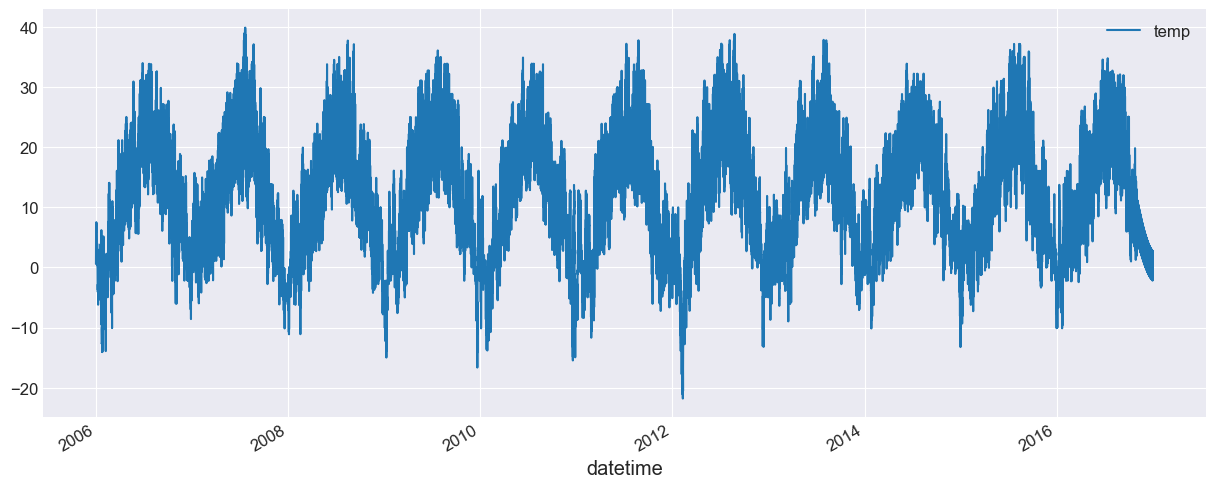

In [86]:
temp_df.plot(x='datetime', y='temp', figsize=(15, 6))

<Axes: xlabel='datetime'>

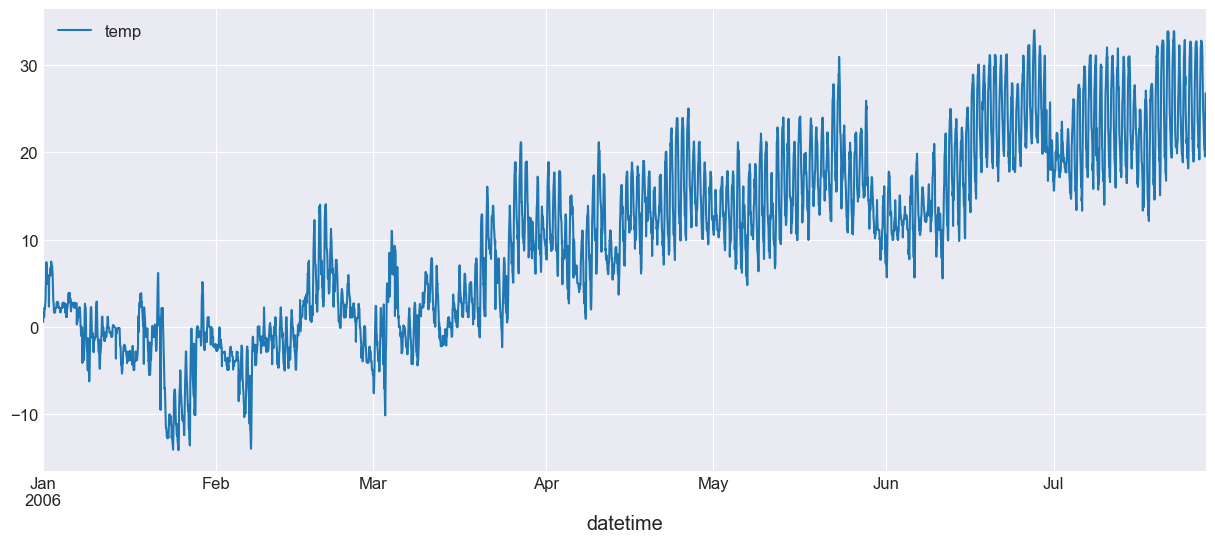

In [87]:
temp_df[:5000].plot(x='datetime', y='temp', figsize=(15, 6))

<Axes: xlabel='datetime'>

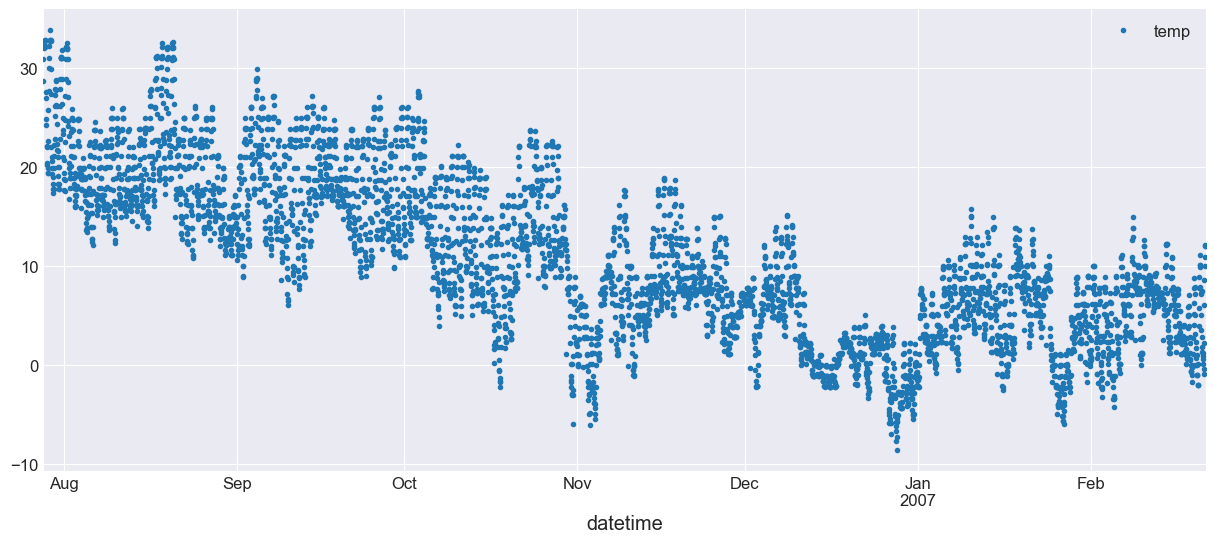

In [88]:
temp_df[5000:10000].plot(x='datetime', y='temp', figsize=(15, 6), style='.')

#### Demo Network

In [89]:
input_shape = (1,10_000)
n_units = 100

model_gigo = tf.keras.models.Sequential()

model_gigo.add(tf.keras.Input(input_shape))
model_gigo.add(tf.keras.layers.SimpleRNN(units=n_units, activation='tanh'))

model_gigo.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [90]:
wax = model_gigo.get_weights()[0].shape
waa = model_gigo.get_weights()[1].shape
baa = model_gigo.get_weights()[2].shape

way = model_gigo.get_weights()[3].shape
bay = model_gigo.get_weights()[4].shape

print(f"Wax: {wax} | Waa: {waa} | Baa: {baa}")
print(f"Way: {way} | Bay: {bay}")

Wax: (10000, 100) | Waa: (100, 100) | Baa: (100,)
Way: (100, 1) | Bay: (1,)


In [91]:
del model_gigo, data_df

In [92]:
temp_df

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333
...,...,...
96448,2016-12-31 18:00:00+00:00,0.488889
96449,2016-12-31 19:00:00+00:00,0.072222
96450,2016-12-31 20:00:00+00:00,-0.233333
96451,2016-12-31 21:00:00+00:00,-0.472222


In [93]:
time_step = 24
y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_df = temp_df.iloc[y_idx]
y_df

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556
...,...,...
96336,2016-12-27 02:00:00+00:00,-1.627778
96360,2016-12-28 02:00:00+00:00,-1.677778
96384,2016-12-29 02:00:00+00:00,-1.727778
96408,2016-12-30 02:00:00+00:00,-1.777778


In [94]:
y_df.shape, len(y_df)*time_step, temp_df.shape

((4018, 2), 96432, (96453, 2))

In [95]:
X_df = temp_df.iloc[range(len(y_df)*time_step)]
X_df.shape

(96432, 2)

In [96]:
X = np.reshape(X_df['temp'].to_numpy(), (y_df.shape[0],time_step))
X.shape

(4018, 24)

In [97]:
X = X[:, :23]
X = np.reshape(X,(X.shape[0],X.shape[1],1))
X.shape

(4018, 23, 1)

### Note:
SimpleRNN expects a 3D tensor, with shape[batch, timesteps, feature]

In [98]:
split = int(BATCH_SIZE*100) # y_df.shape[0]*0.8//32
split

3200

In [99]:
y = y_df.temp.to_numpy()
y

array([ 5.42222222,  1.69444444,  2.2       , ..., -1.72777778,
       -1.77777778, -1.82222222])

In [100]:
X_train = X[:split]
X_test = X[split:]
y_train =y[:split]
y_test = y[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3200, 23, 1), (818, 23, 1), (3200,), (818,))

In [101]:
input_shape = (time_step-1,1)
n_units = 128

model = tf.keras.models.Sequential()

model.add(tf.keras.Input(input_shape))
model.add(tf.keras.layers.SimpleRNN(units=n_units, activation='tanh'))

model.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [102]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
metrics= tf.keras.metrics.RootMeanSquaredError()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metrics])

In [104]:
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test))

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 51.5806 - root_mean_squared_error: 6.9609 - val_loss: 2.1366 - val_root_mean_squared_error: 1.4617
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2746 - root_mean_squared_error: 1.8081 - val_loss: 1.1824 - val_root_mean_squared_error: 1.0874
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7378 - root_mean_squared_error: 1.3176 - val_loss: 0.9227 - val_root_mean_squared_error: 0.9606
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3510 - root_mean_squared_error: 1.1611 - val_loss: 0.7888 - val_root_mean_squared_error: 0.8881
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2825 - root_mean_squared_error: 1.1319 - val_loss: 0.7781 - val_root_mean_squared_error: 0.8821
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2348 - root_mean_squared_error: 1.1106 - val_loss: 0.7369 - val_root_mean_squared_error: 0.8584
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [105]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,24.149763,4.914241,2.136584,1.461706
1,2.903655,1.704011,1.182361,1.087364
2,1.768013,1.329666,0.922700,0.960573
3,1.410514,1.187650,0.788755,0.888119
4,1.266028,1.125179,0.778102,0.882101


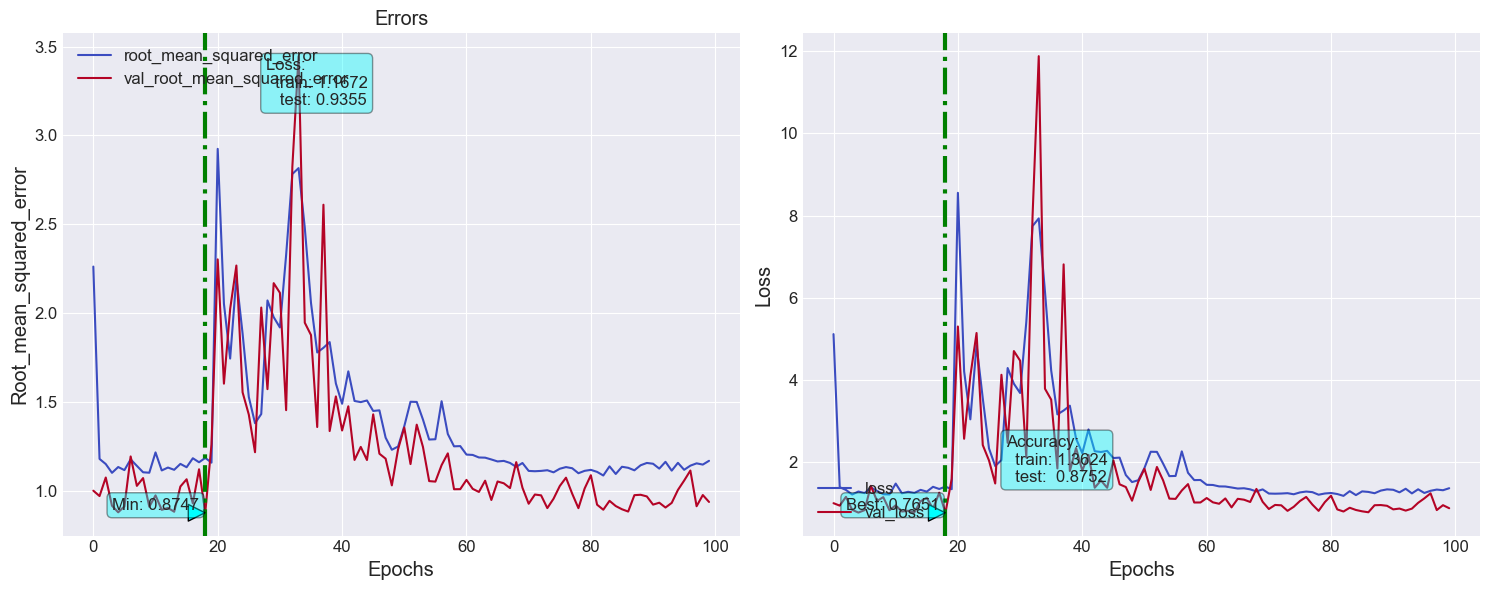

In [72]:
fn_plot_tf_hist(loss_df)

In [106]:
y_train_pred = model(X_train)
y_test_pred = model(X_test)
y_pred =np.append(y_train_pred, y_test_pred)

y_pred.shape

(4018,)

In [107]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,4.543705
48,2006-01-02,1.694444,1.071270
72,2006-01-03,2.200000,1.542682
96,2006-01-04,1.666667,1.417293
120,2006-01-05,1.805556,1.937601


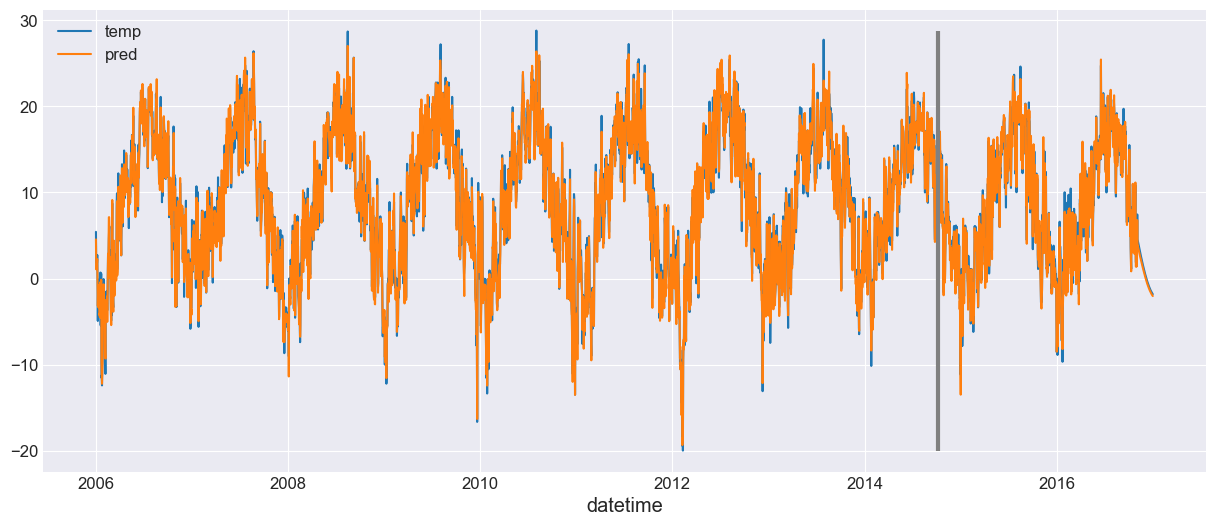

In [109]:
ax = res_df.plot(x='datetime', y=['temp', 'pred'], figsize=(15, 6))
ax.vlines(res_df.iloc[X_train.shape[0]]['datetime'],
         res_df['temp'].min(), res_df['temp'].max(), color='gray', linewidth=3)